### Basic Imports

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import seaborn as sns
import pandas as pd

dist =torch.distributions
import torchsummary

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

from functools import partial

In [64]:
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn

In [65]:
# Create a sine activation class similar to ReLU
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))
        
    def forward(self, x):
        return torch.sin(self.w * x + self.b)

In [66]:
### Vanilla Autoencoder 

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32 * 3, 128),
            Sine(),
            nn.Linear(128, 64),
            Sine(),
            nn.Linear(64, 32),
            Sine()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            Sine(),
            nn.Linear(64, 128),
            Sine(),
            nn.Linear(128, 32 * 32 * 3),
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [68]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

In [69]:
# Train over 1000 images
train_idx = torch.arange(1000)

X = dataset.data[train_idx].to(device)


model = Autoencoder().to(device)

In [70]:
model(X.view(-1, 32 * 32 * 3)).shape

torch.Size([1000, 3072])

In [71]:
# Get reconstruction
def get_reconstruction(model, X, model_type='MLP'):
    with torch.no_grad():
        model.eval()
        if model_type == 'MLP':
           X = X.view(-1, 32 * 32 * 3)
        X_hat = model(X)
        if model_type == 'MLP':
           X_hat = X_hat.view(-1, 3, 32, 32)
        return X_hat

In [72]:
get_reconstruction(model, X).shape

torch.Size([1000, 3, 32, 32])

In [126]:
# Plot original and reconstructed images
def plot_reconstructions(model, X, n=5, model_type='MLP'):
    X = X[:n]
    X_hat = get_reconstruction(model, X, model_type=model_type)
    # Use torchvision.utils.make_grid to make a grid of images
    X_grid = torch.cat([X, X_hat], dim=0)
    X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

/tmp/ipykernel_434735/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


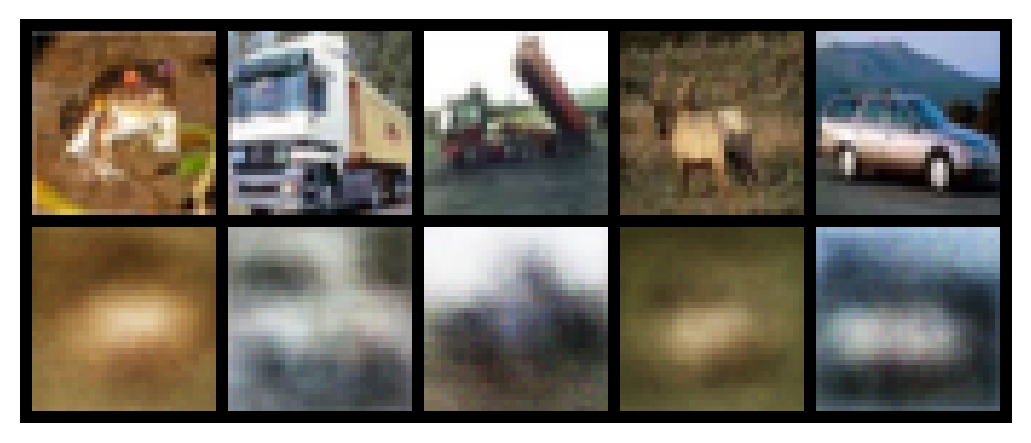

In [127]:
plot_reconstructions(model, X)

In [75]:
setattr(model, 'device', device)
iter_losses, epoch_losses = train_fn(model, X.view(-1, 32 * 32 * 3), X.view(-1, 32 * 32 * 3), nn.MSELoss(), lr=3e-4, 
                                     batch_size=128, epochs=400, verbose=False)


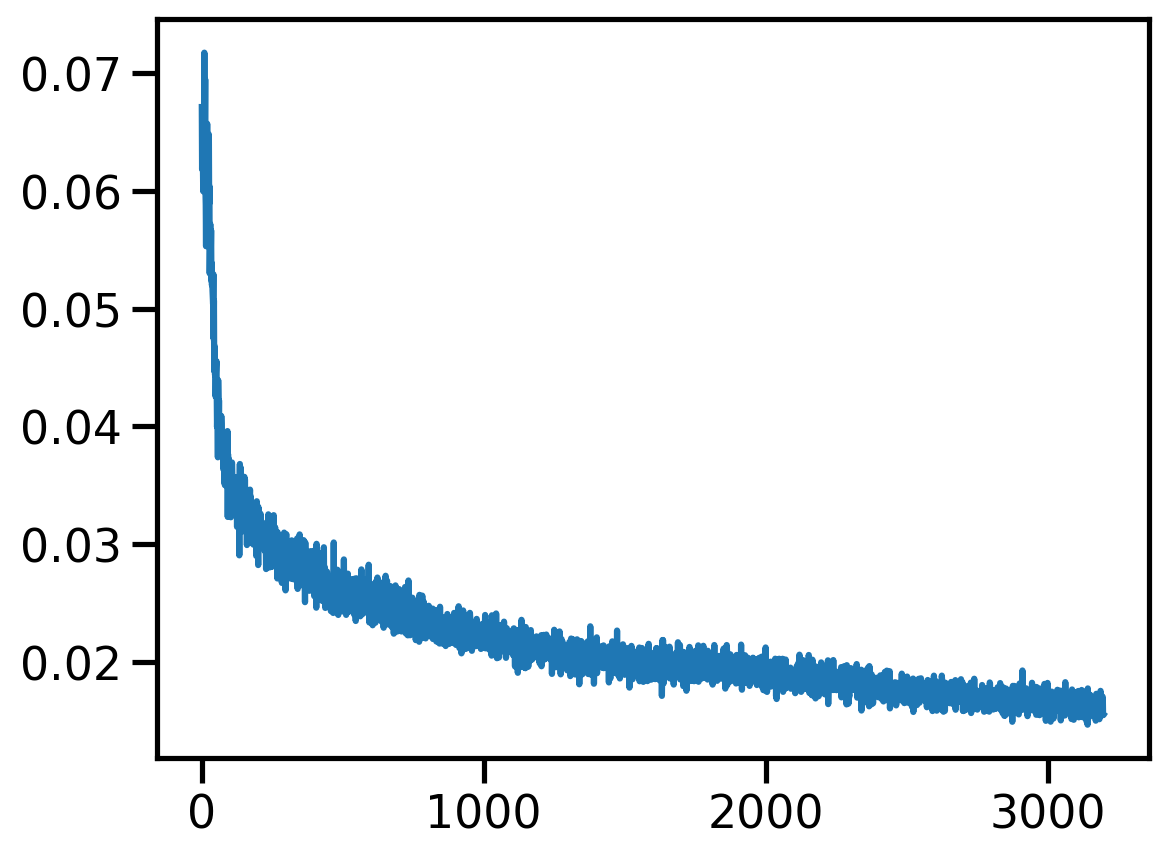

In [76]:
plt.plot(iter_losses)

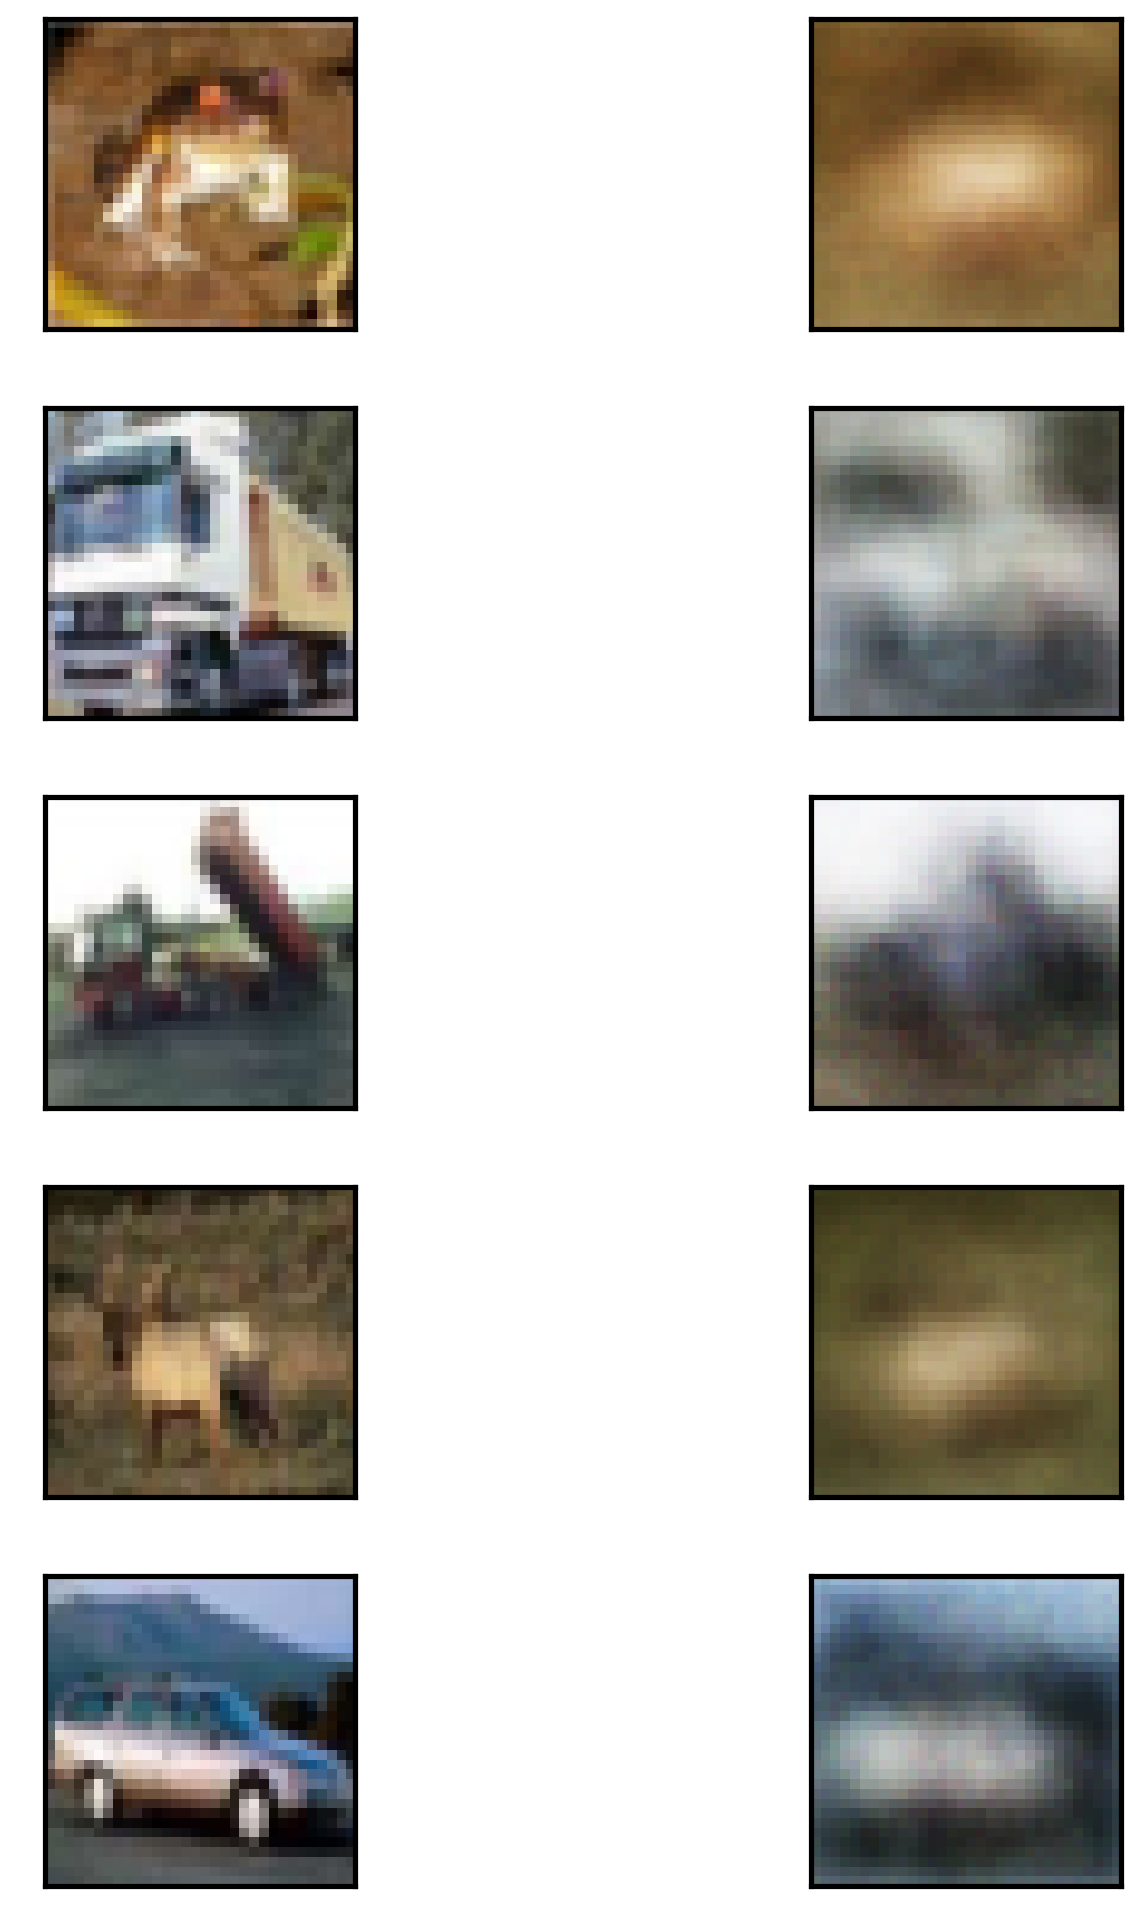

In [78]:
plot_reconstructions(model, X)

In [95]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(ConvAutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), # input: 3 x 32 x 32, output: 16 x 16 x 16
            Sine(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # input: 16 x 16 x 16, output: 32 x 8 x 8
            Sine(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # input: 32 x 8 x 8, output: 64 x 4 x 4
            Sine(),
            # Flatten
            nn.Flatten(), # input: 64 x 4 x 4, output: 1024
            nn.Linear(1024, self.latent_dim), # input: 1024, output: 2
            Sine()
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            # Start from 2 dimensions and go up to 1024
            nn.Linear(self.latent_dim, 1024), # input: 2, output: 1024
            # Reshape to 64 x 4 x 4
            nn.Unflatten(1, (64, 4, 4)), # input: 1024, output: 64 x 4 x 4
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # input: 64 x 4 x 4, output: 32 x 8 x 8
            Sine(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # input: 32 x 8 x 8, output: 16 x 16 x 16
            Sine(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # input: 16 x 16 x 16, output: 3 x 32 x 32
            nn.Sigmoid() # Sigmoid activation for pixel values between 0 and 1
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
                    

In [134]:
latent_dim_ranges = [2, 4, 8, 16, 32, 64, 128]

In [135]:
caes = {}
for latent_dim in latent_dim_ranges:
    caes[latent_dim] = ConvAutoEncoder(latent_dim=latent_dim).to(device)
    setattr(caes[latent_dim], 'device', device)

In [136]:
torchsummary.summary(caes[2], (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              Sine-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
              Sine-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
              Sine-6             [-1, 64, 4, 4]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                    [-1, 2]           2,050
              Sine-9                    [-1, 2]               0
           Linear-10                 [-1, 1024]           3,072
        Unflatten-11             [-1, 64, 4, 4]               0
  ConvTranspose2d-12             [-1, 32, 8, 8]          18,464
             Sine-13             [-1, 32, 8, 8]               0
  ConvTranspose2d-14           [-1, 16,

In [137]:
torchsummary.summary(caes[128], (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              Sine-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
              Sine-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
              Sine-6             [-1, 64, 4, 4]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                  [-1, 128]         131,200
              Sine-9                  [-1, 128]               0
           Linear-10                 [-1, 1024]         132,096
        Unflatten-11             [-1, 64, 4, 4]               0
  ConvTranspose2d-12             [-1, 32, 8, 8]          18,464
             Sine-13             [-1, 32, 8, 8]               0
  ConvTranspose2d-14           [-1, 16,

/tmp/ipykernel_434735/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


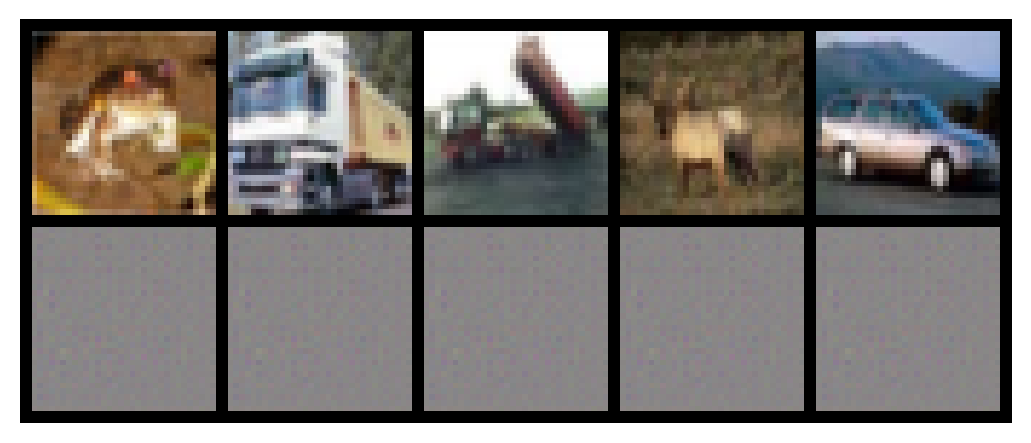

In [138]:
plot_reconstructions(caes[2], X, 5, model_type='CNN')

In [139]:
i_loss = {}
e_loss = {}
for latent_dim in latent_dim_ranges:
    print(f"Training for latent_dim = {latent_dim}")
    i_loss[latent_dim], e_loss[latent_dim] = train_fn(caes[latent_dim], X, X, nn.MSELoss(), lr=3e-4, 
                                                      batch_size=128, epochs=400, verbose=False)


Training for latent_dim = 2
Training for latent_dim = 4
Training for latent_dim = 8
Training for latent_dim = 16
Training for latent_dim = 32
Training for latent_dim = 64
Training for latent_dim = 128


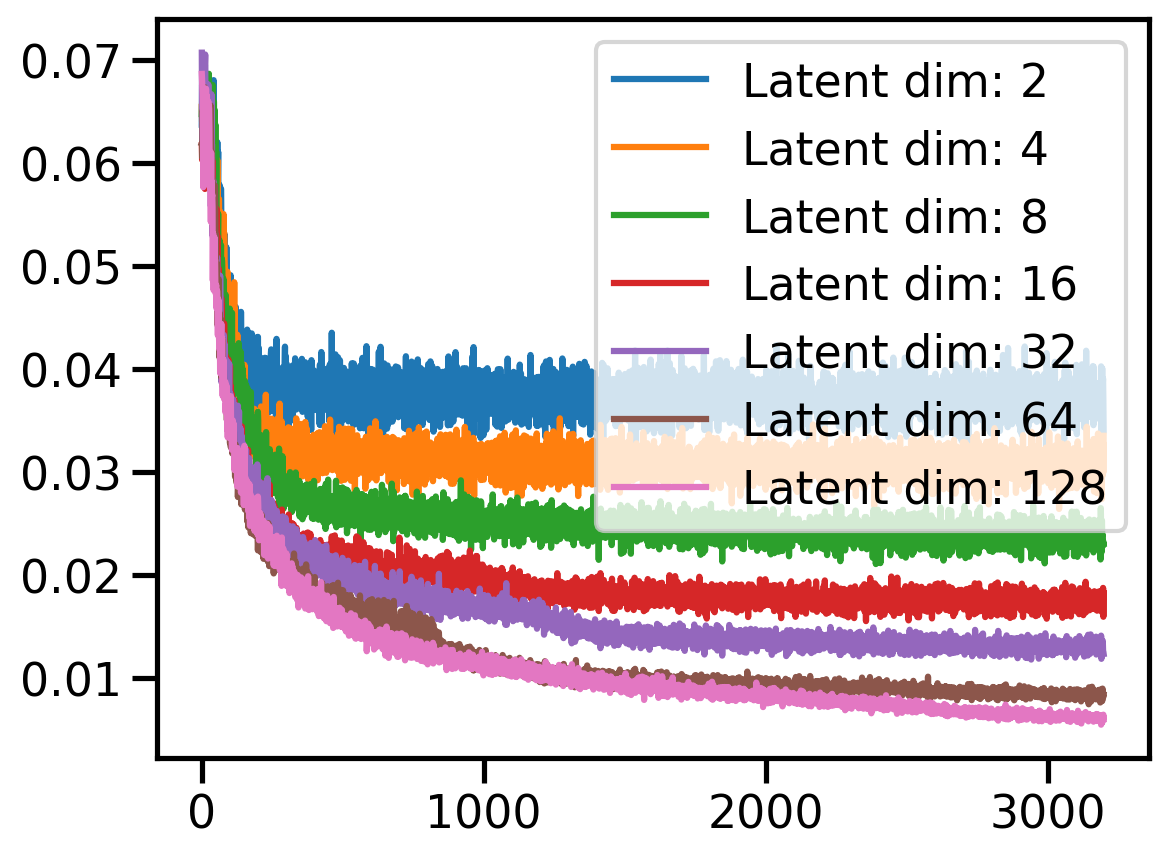

In [140]:
for latent_dim in latent_dim_ranges:
    plt.plot(i_loss[latent_dim], label=f'Latent dim: {latent_dim}')
plt.legend()

/tmp/ipykernel_434735/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


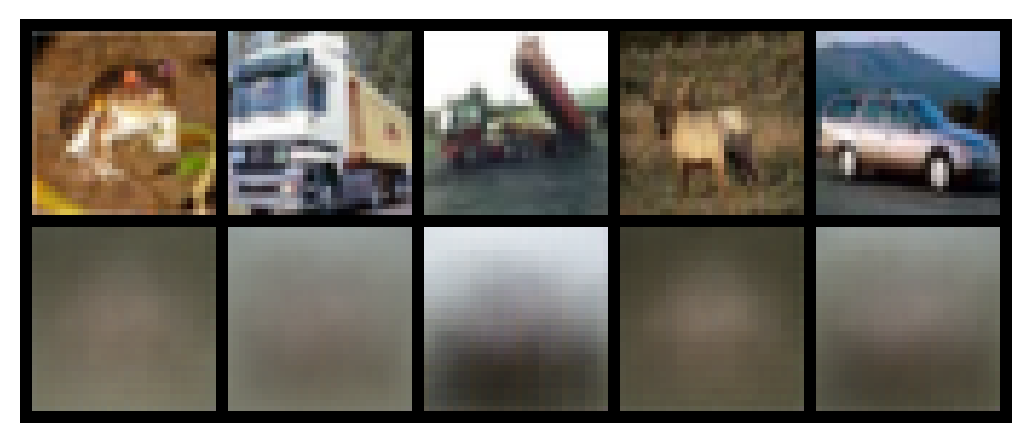

In [147]:
# Plot reconstructions
plot_reconstructions(caes[2], X, 5, model_type='CNN')

/tmp/ipykernel_434735/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


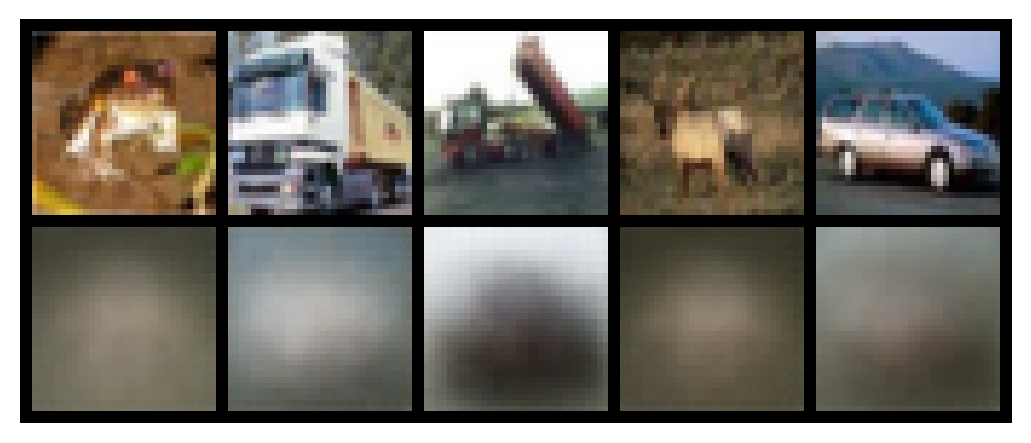

In [142]:
plot_reconstructions(caes[4], X, 5, 'CNN')

/tmp/ipykernel_434735/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


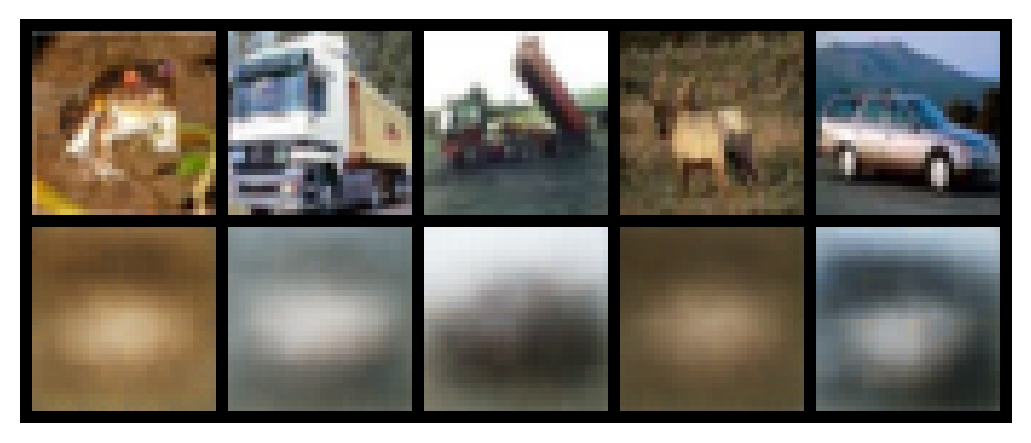

In [148]:
plot_reconstructions(caes[8], X, 5, 'CNN')

/tmp/ipykernel_434735/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


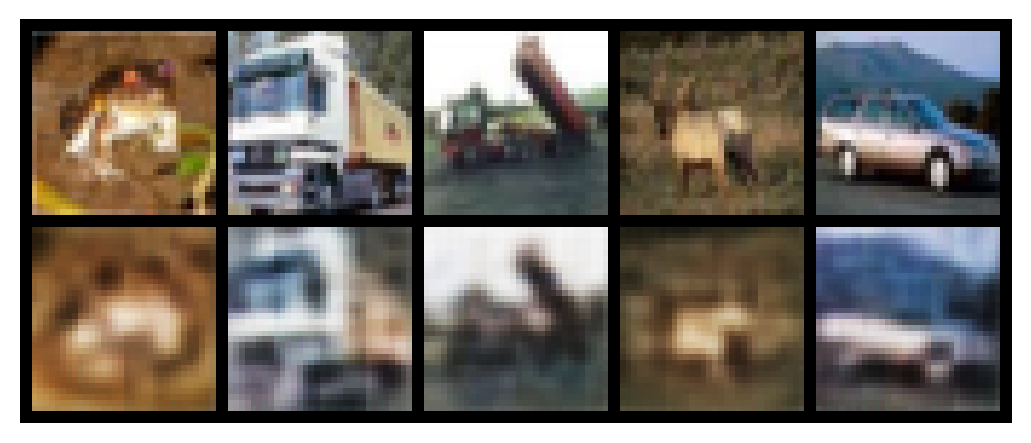

In [149]:
plot_reconstructions(caes[128], X, 5, 'CNN')

In [152]:
# Give a random input to the model and get the output
def get_random_output(model, n=5, latent_dim=2):
    with torch.no_grad():
        model.eval()
        z = torch.randn(n, latent_dim).to(device)
        X_hat = model.decoder(z)
        return X_hat

# Plot random outputs
def plot_random_outputs(model, n=5, latent_dim=2):
    X_hat = get_random_output(model, n, latent_dim)
    X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

/tmp/ipykernel_434735/4035786813.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


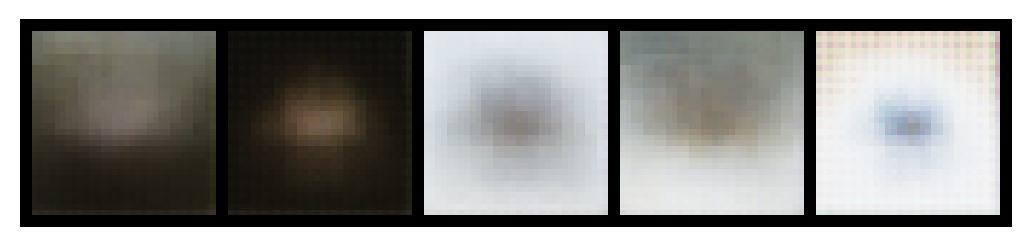

In [153]:
plot_random_outputs(caes[2])

/tmp/ipykernel_434735/4035786813.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


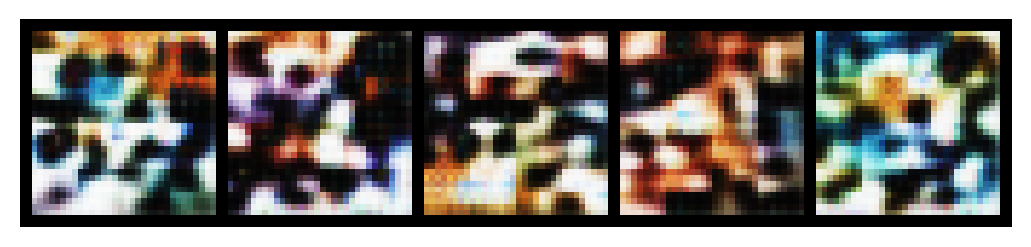

In [154]:
plot_random_outputs(caes[128], latent_dim=128)